## Environmental Source Apportionment Toolkit (ESAT) Workflow

The source apportionment workflow that is available in ESAT replicates the functionality that is found in PMF5. The workflow covers all of the steps for each feature that is available in PMF5:
 1. Data preprocessing, cleanup and analysis.
 2. Source apportionment model creation.
 3. Post-processing analysis and visualizations.
 4. Error estimation analysis of the source apportionment model.
    1. Bootstrap (BS)
    2. Displacement (DISP)
    3. Bootstrap-Displacement (BS-DISP)
 5. Constrained source apportionment model. 

The code provided in this notebook are intended to provide an example of how to implement the ESAT workflow programmaticaly.


In [1]:
# Notebook imports
import os
import sys
import json

In [2]:
# When running from Google Colab or other Jupyter notebook cloud environment, the esat python package may need to be installed.
# If the python package file is available locally run a pip install for the specific wheel for your current OS/Arch
#! pip install esat

#### Code Imports

In [3]:
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis

#### Sample Dataset
The three sample datasets from PMF5 are available for use, but a new dataset can be used in their place.

In [4]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, "..", "data")

# Baton Rouge Dataset
br_input_file = os.path.join(data_dir, "Dataset-BatonRouge-con.csv")
br_uncertainty_file = os.path.join(data_dir, "Dataset-BatonRouge-unc.csv")
br_output_path = os.path.join(data_dir, "output", "BatonRouge")
# Baltimore Dataset
b_input_file = os.path.join(data_dir, "Dataset-Baltimore_con.txt")
b_uncertainty_file = os.path.join(data_dir, "Dataset-Baltimore_unc.txt")
b_output_path = os.path.join(data_dir, "output", "Baltimore")
# Saint Louis Dataset
sl_input_file = os.path.join(data_dir, "Dataset-StLouis-con.csv")
sl_uncertainty_file = os.path.join(data_dir, "Dataset-StLouis-unc.csv")
sl_output_path = os.path.join(data_dir, "output", "StLouis")

#### Input Parameters

In [5]:
index_col = "Date"                  # the index of the input/uncertainty datasets
factors = 6                         # the number of factors
method = "ls-nmf"                   # "ls-nmf", "ws-nmf"
models = 20                         # the number of models to train
init_method = "col_means"           # default is column means "col_means", "kmeans", "cmeans"
init_norm = True                    # if init_method=kmeans or cmeans, normalize the data prior to clustering.
seed = 42                           # random seed for initialization
max_iterations = 20000              # the maximum number of iterations for fitting a model
converge_delta = 0.01               # convergence criteria for the change in loss, Q
converge_n = 50                     # convergence criteria for the number of steps where the loss changes by less than converge_delta
verbose = True                      # adds more verbosity to the algorithm workflow on execution.

#### Dataset Selection
One of the three sample datasets can be selected or a new cleaned dataset can be used. Datasets should be cleaned, containing no missing data (either dropping missing/NaNs, or interpolating the missing values).

In [6]:
# Loading the Baton Rouge dataset
input_file = br_input_file
uncertainty_file = br_uncertainty_file
output_path = b_output_path

#### Load Data
Assign the processed data and uncertainty datasets to the variables V and U. These steps will be simplified/streamlined in a future version of the code.

In [7]:
data_handler = DataHandler(
    input_path=input_file,
    uncertainty_path=uncertainty_file,
    index_col=index_col
)

25-Jul-25 14:54:25 - Input and output configured successfully


#### Input/Uncertainty Data Metrics and Visualizations

In [8]:
# Show the input data metrics, including signal to noise ratio of the data and uncertainty
data_handler.metrics

,Category,S/N,Min,25th,50th,75th,Max
124-Trimethylbenzene,strong,5.445168,0.005000,0.820001,1.290001,1.865001,5.470003
224-Trimethylpentane,strong,5.666667,0.410000,1.580001,2.490002,3.865002,13.560008
234-Trimethylpentane,strong,5.537459,0.005000,0.530000,0.820001,1.300001,4.410003
23-Dimethylbutane,strong,5.500543,0.005000,0.640000,1.110001,2.285001,10.500007
23-Dimethylpentane,strong,5.463626,0.005000,0.340000,0.490000,0.780000,3.310002
2-Methylheptane,strong,5.039088,0.005000,0.215000,0.330000,0.535000,2.480002
3-Methylhexane,strong,5.648208,0.005000,0.655000,1.050001,1.510001,7.780005
3-Methylpentane,strong,5.611292,0.540000,1.720001,2.990002,5.945004,29.100018
Acetylene,strong,5.666667,0.380000,1.410001,1.990001,2.835002,8.070005
Benzene,strong,5.666667,0.590000,1.960001,2.770002,4.440003,9.330006


In [9]:
# Change categories of features
# data_handler.set_category(feature='Unidentified', category='bad')
# data_handler.set_category(feature='Isopropylbenzene', category='weak')
# data_handler.set_category(feature='N-Propylbenzene', category='weak')
# data_handler.metrics

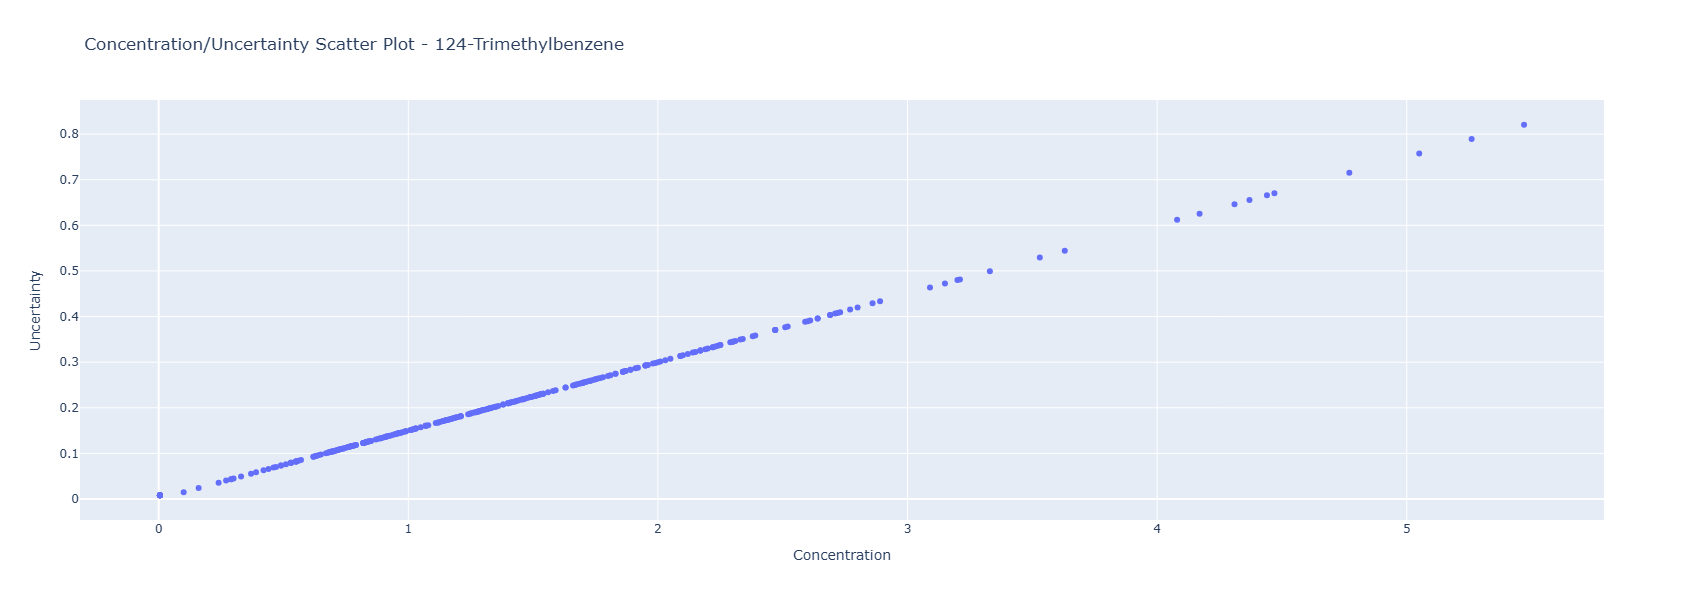

In [10]:
# Concentration / Uncertainty Scatter plot for specific feature, feature/column specified by index
data_handler.plot_data_uncertainty(feature_idx=0, include_menu=False)

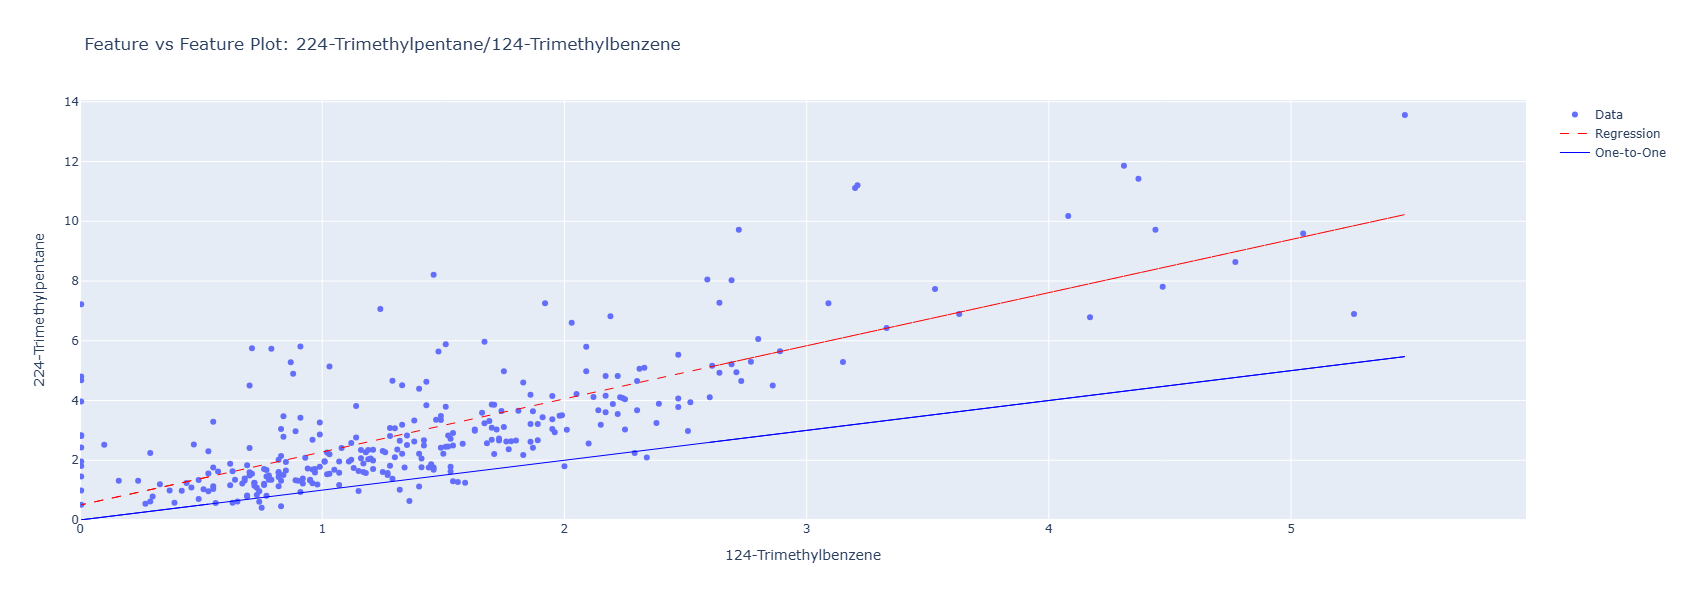

In [11]:
# Species Concentration plot comparing features, features/columns specified by index
data_handler.plot_feature_data(x_idx=0, y_idx=1)

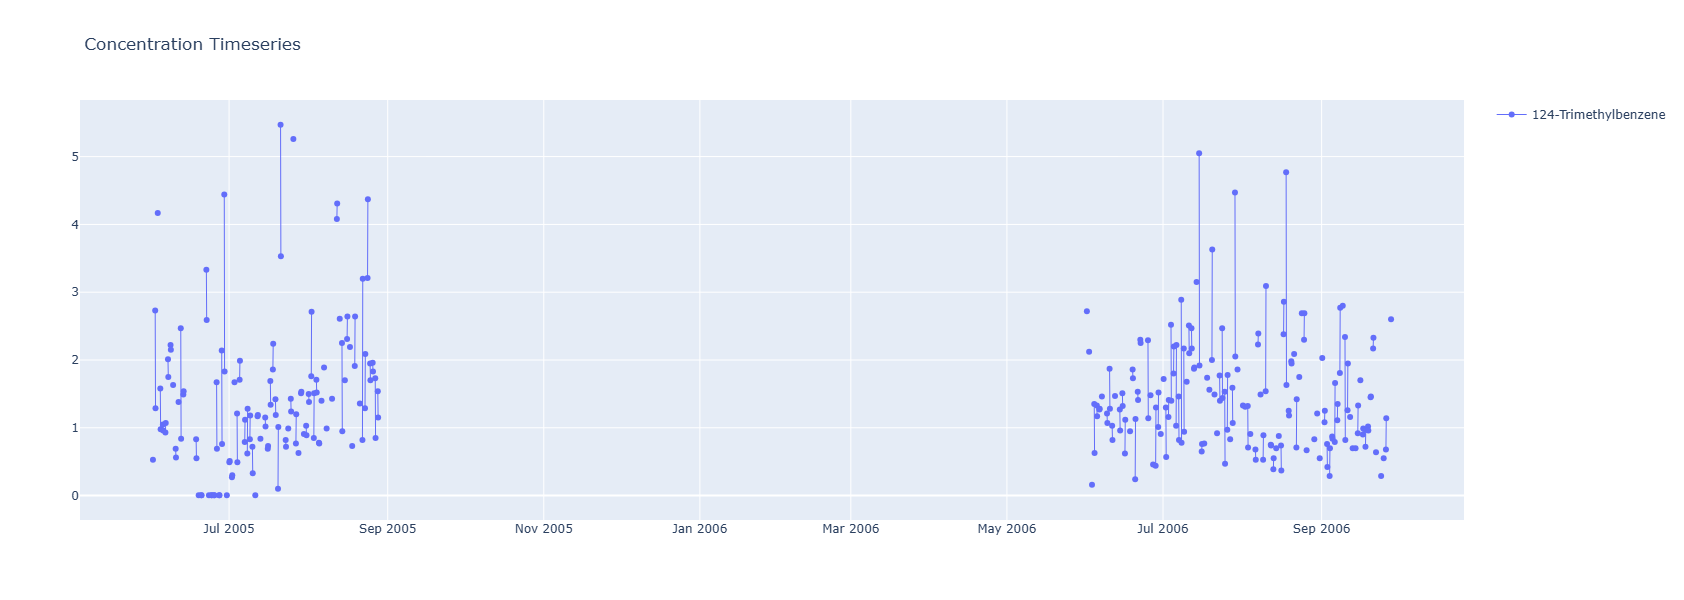

In [12]:
# Species Timeseries, a single or list of features/columns specified by index
data_handler.plot_feature_timeseries(feature_selection=[0])

In [ ]:
data_handler.plot_2d_histogram(x_col="124-Trimethylbenzene", y_col="224-Trimethylpentane")

In [ ]:
# Get the processed data and uncertainty
V, U = data_handler.get_data()

#### Train Model

In [ ]:
%%capture
# Training multiple models
sa_models = BatchSA(V=V, U=U, factors=factors, models=models, method=method, seed=seed, max_iter=max_iterations,
                    init_method=init_method, init_norm=init_norm,
                    converge_delta=converge_delta, converge_n=converge_n,
                    verbose=verbose
                   )
_ = sa_models.train()

In [ ]:
# Selet the best performing model to review
best_model = sa_models.best_model
sa_model = sa_models.results[best_model]
best_model

In [ ]:
# Save the batch SA instance
# batch_name = "test_batch_01"
# batch_output_dir = os.path.join(os.getcwd(), "test_batch")
# os.mkdir(batch_output_dir)
# pickle_model = True
# pickle_batch = True
# header = data_handler.features
# sa_models.save(batch_name=batch_name, output_directory=batch_output_dir, pickle_model=pickle_model, pickle_batch=pickle_batch, header=header)

In [ ]:
# Load the saved batch SA instance
# saved_batch_file = os.path.join(os.getcwd(), "test_batch", "test_batch_01.pkl")
# batch_sa2 = BatchSA.load(file_path=saved_batch_file)

In [ ]:
# Perform batch model analysis
batch_analysis = BatchAnalysis(batch_sa=sa_models, data_handler=data_handler)
# Plot the loss of the models over iterations
batch_analysis.plot_loss()

In [ ]:
# Plot the loss distribution for the batch models
batch_analysis.plot_loss_distribution()

In [ ]:
# Plot the temporal residuals for a specified feature, for all models.
batch_analysis.plot_temporal_residuals(feature_idx=0)

In [ ]:
# Initialize the Model Analysis module
model_analysis = ModelAnalysis(datahandler=data_handler, model=sa_model, selected_model=best_model)

In [ ]:
# Residual Analysis shows the scaled residual histogram, along with metrics and distribution curves. The abs_threshold parameter specifies the condition for the returned values of the function call as those residuals which exceed the absolute value of that threshold.
abs_threshold = 3.0
threshold_residuals = model_analysis.plot_residual_histogram(feature_idx=0, abs_threshold=abs_threshold)

In [ ]:
model_analysis.features_metrics()

In [ ]:
# The model output statistics for the estimated V, including SE: Standard Error metrics, and 3 normal distribution tests of the residuals (KS Normal is used in PMF5)
model_analysis.calculate_statistics()
model_analysis.statistics

In [ ]:
# Model feature observed vs predicted plot with regression and one-to-one lines. Feature/Column specified by index.
model_analysis.plot_estimated_observed()

In [ ]:
# Model feature timeseries analysis plot showing the observed vs predicted values of the feature, along with the residuals shown below. Feature/column specified by index.
model_analysis.plot_estimated_timeseries()

In [ ]:
# Factor profile plot showing the factor sum of concentrations by feature (blue bars), the percentage of the feature as the red dot, and in the bottom plot the normalized contributions by date (values are resampled at a daily timestep for timeseries consistency).
# Factor specified by index.
model_analysis.plot_factor_profile(factor_idx=1)

In [ ]:
# All factor profile plots showing the factor sum of concentrations by feature (blue bars) and the percentage of the feature as the red dot.
model_analysis.plot_all_factors()

In [ ]:
# Plot all factor profiles as 3d plot showing either the factor sum of concentrations by feature (blue bars) and the percentage of the feature as the red dot.
model_analysis.plot_all_factors_3d()

In [ ]:
# Model factor fingerprint specifies the feature percentage of each factor.
model_analysis.plot_factor_fingerprints()

In [ ]:
# Factor G-Space plot shows the normalized contributions of one factor vs another factor. Factor specified by index.
model_analysis.plot_g_space(factor_1=2, factor_2=1)

In [ ]:
# Factor contribution pie chart shows the percentage of factor contributions for the specified feature, and the corresponding normalized contribution of each factor for that feature (bottom plot). Feature specified by index.
model_analysis.plot_factor_contributions(feature_idx=1)

In [ ]:
# New Graphic: Factor Profile Composition Radar Graph
model_analysis.plot_factor_composition()

In [ ]:
# New Graphic: Factor Contribution Surface Plot
factor_idx = None
feature_idx = 1
model_analysis.plot_factor_surface(factor_idx=factor_idx, feature_idx=feature_idx, percentage=True)

### Error Estimation - Displacement

The displacement method for error estimation works by make slight adjustments to the factor profile values, individually, until a specific change in the loss value (dQ) is reached. There are 4 dQ values that are targetted, dQ = 4, 8, 16, 32. 

The target dQ value is run for both an increase and decrease in the factor profile value, a single value in the factor profile matrix at a time. The change in factor profile is found by running a modified binary search to identify the value change within a small threshold, 0.1 of the target dQ. The value search is stopped if the change in the factor profile value is less than 1e-8, in the instance that decreasing a factor profile value already near zero.

Once the change in the factor profile value is found that produces the target dQ, both increasing and decreasing, the modification to the H matrix is used as an initial guess for retraining a SA model. The W matrix is reinitialized, using the original base model seed, and the model is trained to convergence. 

The resulting model factor profile is checked to see if any factors swapped base upon the highest factor correlation with the base model factors. The output shows the swap %, based upon the number of retrained models where that factor was modified and the number of times a swap was detected.

The factor profile plot shows the variability in the factor profile feature values that correspond to the dQ target values, default shown in the plots is for a dQ=4. The last plot show the factor feature contribution variability based upon the same changes to the H matrix.

In [ ]:
# Import Error Estimation Displacement Method
from esat.error.displacement import Displacement

In [ ]:
# Initialize the Displacement method, passing in the results of the batch SA run and the features labels from the data handler.
# features=None will run displacement on all features in the solution.
disp = Displacement(sa=sa_model, feature_labels=data_handler.features, model_selected=best_model, features=[0,1,2])

In [ ]:
%%time
# Execute the displacement model, which will test both increasing and decreasing changes to the individual values of H for all dQ targets. Results are then compiled and prepared.
disp.run()

In [ ]:
# The swap table shows the percentage of times a factor was found to be more highly correlated as a result of the change in the factor feature value. This percentage is the number of times that a specific factor swapped after a model was retrained.
# The largest change in the dQ value is the largest difference (both from increasing and decreasing changes to the factor feature values) between a retrained model and the base model loss value.
disp.summary()

In [ ]:
# The results for a specific factor can be plotted, showing both the variability in the profile(%) and contribution for a given dQ value.
factor_i = 3
disp.plot_results(factor=factor_i)

### Error Estimation - Bootstrap

The bootstrap method used is the block bootstrap method for time-series data. Here the initial dataset is broken into chunks of a specified size, containing sequential samples, and randomly added to a bootstrap dataset until the bootstrap dataset is the same size as the initial dataset.

A recommended block size calculation is performed when data is initially loaded into the DataHandler and found as the <i>optimal_block</i> variable.

The aim of the bootstrap method is to quantify the variability in the factor profiles and contributions when the order of the datasets have been shuffled, resampled. In this case the block bootstrap method is the default method, while the full bootstrap method can be used by setting the block parameter in the run function to false, i.e. bs.run(block=False). The blocks are randomly selected with replacement, allowing for the same block to be added to the bs dataset more than once. The final selected block is reduced in size until the bs dataset is exactly the same as the initial dataset. 

The resampling is completed a specified number of times, set by bootstrap_n. During each bootstrap run, the initial datasets are resampled (both the data and uncertainty datasets are resampled using the same indeces) and used to retrain a SA model. The SA model uses the resampled data and uncertainty data, the base model H matrix and the base model random seed. W is reinitialized and the model is trained to convergence. The resulting factor contributions, $V'_{bs}$ are mapped to the base model $V'_{base}$, where the correlation between all combinations of the factor contributions are checked. The mapping between the highest correlation is then noted, if the correlation is above the user specified threshold (default=0.6), and the results are shown in the summary statistics. The summary statistics also include metrics for the distribution of the bootstrap model results to compare against the base model results, these are shown as tables for each factor in the summary statistics.

The results of all the bootstrap runs are compiled to provide a distribution for each factor/feature percentage and contribution, these are shown in the plotted results.

In [ ]:
# Import Bootstrap Error Estimation Method
from esat.error.bootstrap import Bootstrap

In [ ]:
# Bootstrap input parameters
model_selected = sa_models.best_model               # the model selected to be the base model for the Bootstrap method, here chosen as the best performing model from the batch SA run.
nmf_model = sa_models.results[model_selected]       # The selected model SA model.
feature_labels = data_handler.features              # The list of feature names/labels

bootstrap_n = 20                                    # The number of bootstrap runs to complete
block_size = data_handler.optimal_block             # Calculates an optimal block size from the Politis and White 2004 algorithm (used in PMF5)
threshold = 0.6                                     # The r-correlation threshold
seed = seed                                         # The random seed used for random selection of the bootstrap blocks.
print(f"Optimal BS block size: {data_handler.optimal_block}")

In [ ]:
# Initialize the bootstrap object
bs = Bootstrap(sa=sa_model, feature_labels=feature_labels, model_selected=model_selected, bootstrap_n=bootstrap_n, block_size=block_size, threshold=threshold, seed=seed, parallel=True)

In [ ]:
%%time
# Execute the bootstrap runs with default parameters
bs.run()

In [ ]:
# Print the output summary of all the bootstrap runs.
bs.summary()
# bs.bs_results[1]['mapping']

In [ ]:
# Plot the results of the bootstrap runs for a specific factor, showing the variability in percentage and concentration for each feature of the specified factor.
# factor_i = 1
# bs.plot_results(factor=factor_i)
bs.q_results

### Error Estimation - Bootstrap-Displacement

The bootstrap-displacement (BS-DISP) method is a combination of the boostrap and displacement methods. An existing BS instance can be used, or a new BS instance will be created.

The BS-DISP method runs a BS instance and for each model in the BS run, DISP is run for each of the features specified or all by default. The results are similar to the DISP results by are aggregated across all bootstrap runs.

In [ ]:
from esat.error.bs_disp import BSDISP

In [ ]:
# Bootstrap input parameters (Shared with BS-DISP)
model_selected = sa_models.best_model              # the model selected to be the base model for the Bootstrap method, here chosen as the best performing model from the batch nmf run.
sa_model = sa_models.results[model_selected]      # The selected model SA object.
feature_labels = data_handler.features              # The list of feature names/labels

bootstrap_n = 10                                    # The number of bootstrap runs to complete
block_size = data_handler.optimal_block             # Calculates an optimal block size from the Politis and White 2004 algorithm (used in PMF5)
threshold = 0.6                                     # The r-correlation threshold
seed = seed                                         # The random seed used for random selection of the bootstrap blocks.

# Displacement input parameters (Shared with BS-DISP)
threshold_dQ = 0.1
max_search = 50
features = [0, 1, 2]

In [ ]:
# Initialize BS-DISP with the BS and DISP parameters
bsdisp = BSDISP(sa=sa_model, feature_labels=feature_labels, model_selected=model_selected, bootstrap_n=bootstrap_n, block_size=block_size, threshold=threshold, max_search=max_search, threshold_dQ=threshold_dQ, features=features, seed=seed)

In [ ]:
%%capture
# Execute the BS-DISP instance, which will first run BS (if required) then will run DISP for each BS model.
bsdisp.run()

In [ ]:
# Print the summary table and general metrics
bsdisp.summary()

In [ ]:
# Plot the BS-DISP results, the profile and contribution boxplots for a specific factor.
factor_i = 1
bsdisp.plot_results(factor=factor_i)

In [ ]:
# The overall error summary can be shown through the follow method that will take in an existing bootstrap and displacement object and plot the error estimation for a given factor.
from esat.error.error import Error

In [ ]:
# Pass in the previously completed bootstrap and displacement instances
error = Error(bs=bs, disp=disp, bsdisp=bsdisp)

In [ ]:
# Plot the error estimation of the concentration for a specified factor.
factor_i = 1
error.plot_summary(factor=factor_i)

### Constrained Model

The constrained model provides the functionality for a user to use their prior knowledge about the source profiles to place limits and constraints on factor elements of the solution.

The constrained model allows for two different options for placing these limits on the values of the solution, expressions and constraints. Constraints allow for a user to set precise limits on the value of a factor element, through several different constraint types. Expressions allow for the user to define how a factor element value is related to one or more other factor element values. These expressions are limited by the change in Q as a results of the new factor element values.

Both constraints and expressions are evaluated at every iteration of the constrained model run, with expressions occuring first and the constraints being applied second. Constraints are either determined exactly prior to running the model, limited by a bounds, or are calculated by a value that results in a target dQ. Expressions are dynamic as the values and sum of the expression can change from one iteration to the next.

Expressions are evaluated collectively as a set of linear equations, converted into matrix form. Such that:</br></br>
$$c1*x1 + c2*x2 = 0$$
$$c3*x3 - c4*x4 + c5*x5 = 0$$
$$c6*x2 + c7*x5 = 0$$
is equivalent to
$$\begin{bmatrix}
c1 & c2 & 0 & 0 & 0 \\
0 & 0 & c3 & -c4 & c5 \\
0 & c6 & 0 & 0 & c7 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}$$ 

The matrix of expressions is evaluated at each iteration to account for updates to the factor elements, both from the constraints and the update algorithm.

A completed constrained model run will provided a constrained model which can then be used on any of the error estimation methods, by passing the .constrained_model (NMF) as the base model was originally.

In [ ]:
# Import the Constrained Model module
from esat.rotational.constrained import ConstrainedModel

cm = ConstrainedModel(base_model=sa_model, data_handler=data_handler, softness=1.0)

#### Adding Constraints
There are 6 different constraint types available:</br>
"pull down", "pull up", "pull to value", "set to zero", "set to base value", "define limits"

The target of the constraint can be either "feature" (H) or "sample" (W)

Additional parameters are available in the add_constraint method depending upon the constraint type specified:</br>
'define limits' requires a min_value and a max_value parameter to be provided.</br>
'pull to value' requires a target_value and dQ parameter to be provided.</br>
'pull down' and 'pull up' require the dQ parameter to be provided.</br>

Constraints are added to a constrained model by the .add_constraint() method. A factor element can only have one constraint.</br>
Note that the index of the matrices are 'feature'=(index of factor, index of feature) and 'sample'=(index of sample, index of factor) 

In [ ]:
# Add a 'set to zero 'constraint on the Factor-Feature matrix (H) index (0, 3)
cm.add_constraint(constraint_type="set to zero", index=(0,3), target="feature")

In [ ]:
# Add a 'define limits' constraint
cm.add_constraint(constraint_type="define limits", index=(2,10), target="feature", min_value=0.1, max_value=0.9)

In [ ]:
# Add 'pull up' and 'pull down' constraints
# cm.add_constraint(constraint_type="pull up", index=(2, 15), target="feature", dQ=100)
# cm.add_constraint(constraint_type="pull down", index=(5, 1), target="feature", dQ=50)

In [ ]:
# Add 'set to base value' constraint
# cm.add_constraint(constraint_type='set to base value', index=(3, 3), target="feature")

In [ ]:
# Add 'pull to value' constraint
# cm.add_constraint(constraint_type='pull to value', index=(4, 20), target="feature", target_value=2.5, dQ=50)

In [ ]:
# Display all constraints
cm.list_constraints()

In [ ]:
# Constraints can be remove before training the model with 'constraint_model.remove_constraint(constraint_label=LABEL)' where LABEL is the string 'factor:I|feature:J', also shown when the constraints are listed.
cm.remove_constraint(constraint_label='factor:0|feature:3')
cm.list_constraints()

#### Adding Expressions
An expression is an equation involving 2 or more factor elements (from either W or H) where each factor element has a coefficient and the equation equals 0.</br>

A factor element is defined by the string 'factor:F|feature:K' or 'factor:F|sample:J' where F, K, J are indecies. The factor element is defined inside of [ ], such as '[factor:1|feature:1]'.</br> 

A coefficient is placed in front of the factor element, and must be present (set to 1.0 in those cases). The coefficient of a factor element is structured like '10.0*[factor:2|feature:10]'</br>
These coefficient/factor element terms are bounded by () and between multiple terms can be the +/- operator. The equations are all equal to zero.

The expression string contains two components, the expression itself and a number that specifies the dQ limit.

Examples of expression strings:

"(0.66*[factor:1|feature:2])-(4.2*[factor:2|feature:4])=0,250"</br>
"(0.35*[factor:0|feature:3])-(2.0*[factor:1|feature:3])-(3.7*[factor:3|feature:4])=0,250"</br>
"(3.2*[factor:2|feature:4])+(1.2*[factor:3|feature:10])+(0.1*[factor:1|feature:3])+(20.0*[factor:4|feature:3])-(10.7*[factor:5|feature:4])=0,250"</br>

The expressions are solved at each iteration where the equation is set to equal the sum of all factor elements. These expressions are solved as a single linear equation, with the sum of all dQ limits used to reduce the change from the original values to the solved target values.

There is currently no limit on the number of expressions or the number of times a factor element can be in an expression. A factor element can be in both a constraint and one or more expressions.

During each iteration of the constained model training method, the expressions are evaluated first and then the constraints are applied. These constraint and expressions results are used to calculate a difference matrix, which is used to modify the solution matrix. The difference matrix is the difference between the constrained target values and the current solution.

In [ ]:
# Here are three example expressions where each term is defined inside (), containing a coefficient and factor element.
expression1 = "(0.66*[factor:1|feature:2])-(4.2*[factor:2|feature:4])=0,250"
expression2 = "(0.35*[factor:0|feature:3])-(2.0*[factor:1|feature:3])-(3.7*[factor:3|feature:4])=0,250"
expression3 = "(3.2*[factor:2|feature:4])+(1.2*[factor:3|feature:10])+(0.1*[factor:1|feature:3])+(20.0*[factor:4|feature:3])-(10.7*[factor:5|feature:4])=0,250"

In [ ]:
# Expressions are added with the add_expression function
cm.add_expression(expression1)
cm.add_expression(expression2)
# cm.add_expression(expression3)

In [ ]:
# All expressions currently added for the model can be listed using the list_expressions() function
cm.list_expressions()

In [ ]:
# An expression can be removed with the .remove_expression and the expression index as found in the list of 
# cm.remove_expression(expression_idx=0)
# cm.list_expressions()

In [ ]:
# Once all the constraints and expressions have been defined and added. We can tain the constrained model.
# When the model is finished training, a new NMF model is availble in the constrained_model object as the constrained_model variable
cm.train(max_iterations=20000)

In [ ]:
# Print the results of the constrained model run, as seen in the PMF5 results.
cm.display_results()
# Show the plot of how Q changes during the constrained model training. Qtype can be 'True', 'Robust', 'aux'.
cm.plot_Q(Qtype="Aux") # Qtype: True, Robust, Aux

In [ ]:
# Evaluate the constraints factor elements from the constrained model solution.
# Note: values may be different than the target valuve or range as expressions and constraints are applied before the matrix update algorithm.
cm.evaluate_constraints()

In [ ]:
# Evaluate expression factor elements from the constrained model solution. Includes calculating current value of expressions.
cm.evaluate_expressions()

In [ ]:
# Plot the profile and contribution graphs of the constrained model for a specified factor index.
cm.plot_profile_contributions(factor_idx=1)

In [ ]:
# Plot the factor fingerprint stacked bar graph for the constrained model
cm.plot_factor_fingerprints()

In [ ]:
# Plot the g space graph for the constrained model.
# Two optional arguments are available: show_base=Boolean, show_delta=Boolean. These default to False.
cm.plot_g_space(factor_idx1=1, factor_idx2=2, show_base=True, show_delta=True)

In [ ]:
# Plot the factor contributions of the constrained model for a specified feature.
cm.plot_factor_contributions(feature_idx=4)

#### Constrained Model Error Methods

The constrained model solution can also be used in the error estimation methods in the same way the SA model was used. Once the constrained model finds a solution, a new SA model is available with the constrained model W and H matrices and other parameters. The new constrained SA model is the ConstrainedModel.constrained_model variable.

In [ ]:
cm_model = cm.constrained_model

In [ ]:
# Initialize the Displacement method, passing in the results of the constrained nmf run and the features labels from the data handler.
cm_disp = Displacement(sa=cm_model, feature_labels=data_handler.features, model_selected="constrained", features=[0,1,2,3,4])

In [ ]:
%%time
# Execute the displacement model
cm_disp.run()

In [ ]:
# Show cosntrained model displayment summary
cm_disp.summary()

In [ ]:
# Plot the results from the constrained model displacement results
factor_i = 1
cm_disp.plot_results(factor=factor_i)

In [ ]:
# Bootstrap input parameters (the same as the base model BS parameters except for the SA model used.)
feature_labels = data_handler.features              # The list of feature names/labels

bootstrap_n = 20                                    # The number of bootstrap runs to complete
block_size = data_handler.optimal_block             # Calculates an optimal block size from the Politis and White 2004 algorithm (used in PMF5)
threshold = 0.6                                     # The r-correlation threshold
seed = seed                                         # The random seed used for random selection of the bootstrap blocks.
print(f"Optimal BS block size: {data_handler.optimal_block}")

In [ ]:
# Initialize the bootstrap object (changes are to the nmf parameter and the model_selected which is used for labeling in the results)
cm_bs = Bootstrap(sa=cm_model, feature_labels=feature_labels, model_selected="constrained", bootstrap_n=bootstrap_n, block_size=block_size, threshold=threshold, seed=seed)

In [ ]:
%%time
# Execute the constrained model bootstrap runs
cm_bs.run()

In [ ]:
# Print the output summary of all the constrained bootstrap runs.
cm_bs.summary()

In [ ]:
# Plot the results of the constrained bootstrap runs for a specific factor, showing the variability in percentage and concentration for each feature of the specified factor.
factor_i = 1
cm_bs.plot_results(factor=factor_i)